# Fairy circle formation by nutrient depletion

# Plant-nutrient models

The model describes the dynamics of a plant $P$ and nutrient $N$, using the following differential equations:

$$
\begin{aligned}
\frac{\partial P}{\partial t}&= r P \frac{N}{k_{1}+N} -d P + D_{p} \Delta P\\
\frac{\partial N}{\partial t}&= I_{\rm in} + s d P - c P \frac{N}{k_{1}+N} + D_{n} \Delta N
\end{aligned}
$$

See Table S1 for details definitions and explanations. 

In [16]:
from __future__ import absolute_import, print_function
import time
import numpy as np
import pyopencl as cl
import matplotlib.pyplot as plt
from scipy import signal
from matplotlib import rcParams

# Widening the screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

rcParams['figure.dpi'] = 300
rcParams['font.size'] = 16
rcParams['font.family'] = 'StixGeneral'
plt.rc('font', size=16)          # controls default text sizes
plt.rc('axes', titlesize=16)     # fontsize of the axes title
plt.rc('axes', labelsize=16)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=16)  # fontsize of the figure title

### Parameter definition 

In [17]:
# parameters
c    = 0.1     # convert from biomass to nutrient loss
d    = 0.25    # death rate of plants because of nutrient deficiency
k1   = 5.0     # half saturation constant of soil water uptake
r    = 0.6     # growth rate of plants
s    = 0.02    # convert dead plant biomass to nutrient
Iin  = 0.15    # Nutrient content of the water
Dp   = 0.002   # dispersal rate of plants
Dn   = 0.02    # dispersal rate of plants

### Simulation settings

In [18]:
length    = 50.0       # 2.5 Length of the physical landscape
n         = 512        # Size of the 2D grid
endtime   = 500.0     #end time
dT        = 0.05       #calculate time step
nplot     = 300
plottime  = endtime/nplot
nsteps    = np.ceil(plottime/dT).astype(int)    #number of time steps

### Precalculations

In [19]:
dX = 2*length/n      # Spatial step size
dY = 2*length/n      # Spatial step size
Grid_Width  = n
Grid_Height = n
# %% Reporting in the simulation on the console
print(" Current grid dimensions: %d x %d cells\n" % (Grid_Width, Grid_Height));

 Current grid dimensions: 512 x 512 cells



### Defining the device that is used

In [20]:
# Setting up the OpenCL context
DeviceNr = 1   # 0 = GTX 960M
platform = cl.get_platforms()
Devices  = platform[0].get_devices()  # 0 = GPU
context  = cl.Context([Devices[DeviceNr]])
queue    = cl.CommandQueue(context)
mf       = cl.mem_flags # Memory flags are set
print(" Compute Device: %s\n" % Devices[DeviceNr].name)

 Compute Device: AMD Radeon R9 M395X Compute Engine



### Initial values

In [21]:
# The array is allocated on the GPU and the initial values are copied onto it
im      = np.zeros((n, n))+1.0
N_host  =(im.reshape(n*n)).astype(np.float32)
#N_host   =  (1.0*(np.random.rand(n*n)<0.000000)).astype(np.float32)
N_g     = cl.Buffer(context, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=N_host)

# # generate single seedlings 
im = np.zeros((n, n))
#ix,iy=np.random.randint(0,n,10),np.random.randint(0,n,10)
im[256,156]=1
im[176,306]=1
im[336,306]=1
P_host=(im.reshape(n*n)).astype(np.float32)
# generate multitude seedlings 
# P_host   =  (1.0*(np.random.rand(n*n)<0.01)).astype(np.float32)
P_g      = cl.Buffer(context, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=P_host)

### Loading the spatial functions from the ipython file

In [22]:
with open('SpatialFunctions_iPy.cl', 'r') as myfile:
   SpatialFunctions = myfile.read()

In [23]:
### Transcribing the 

In [24]:
# List of parameters for the OpenCL kernel. Seperate with comma without spaces
# Setting up the parameters for the Kernel

PassVars="c,r,d,s,Iin,Dp,Dn,k1,dX,dY,dT,Grid_Width,Grid_Height"

PassVals=eval(PassVars)
PassVars=PassVars.split(',')
Params=""

for ii in range(len(PassVals)):
    Params = Params+"#define " + PassVars[ii] + " " + str(PassVals[ii]) + " \n"

### Defining the OpenCL simulation kernel

In [25]:
ComputeCode = """

///////////////////////////////////////////////////////////////////////////////
// Simulation kernel
///////////////////////////////////////////////////////////////////////////////   

__kernel void SimulationKernel (__global float* P, __global float* N)
{

    size_t current  = get_global_id(0);
    size_t row      = floor((float)current/(float)Grid_Width);
    size_t column   = current%Grid_Width;

        if (row > 0 && row < Grid_Width-1 && column > 0 && column < Grid_Height-1)
            {                
             float dPdt = r*P[current]*N[current]/(N[current]+k1) - d*P[current] + Dp*d2_dxy2(P);
             float dNdt = Iin - c*P[current]*N[current]/(N[current]+k1) + s*d*P[current] + Dn*d2_dxy2(N);
             
             P[current] = P[current] + dPdt*dT;
             N[current] = N[current] + dNdt*dT;
            }
            
        // HANDLE Boundaries
        else 
            {
             PeriodicBoundaries(P);
             PeriodicBoundaries(N);
            }

} // End SimulationKernel
"""

### Here the kernel is compiled

In [26]:
program = cl.Program(context, Params + SpatialFunctions + ComputeCode).build()

In [27]:
from ipywidgets import FloatProgress
from IPython.display import display

# Setting up a progress bar for the simulation
print("Progress :");
PB = FloatProgress(min=0, max=nplot); display(PB) 

Ps=np.zeros((Grid_Width, Grid_Height, nplot))
Ns=np.zeros((Grid_Width, Grid_Height, nplot))

# Set up simulation parameters
global_size = P_host.shape

# Start the timer:
start_time = time.time()

# Starting the loop
for ii in range(1,nplot):
    # The simulation
    for jj in range(1,nsteps):      
        program.SimulationKernel(queue, global_size, None, P_g, N_g)

    # Get the data from the GPU
    cl.enqueue_copy(queue, P_host, P_g)
    cl.enqueue_copy(queue, N_host, N_g)
    
    # We store the state of the system for <NumPlot> different times.
    Ps[:,:,ii] = P_host.reshape(Grid_Width, Grid_Height)
    Ns[:,:,ii] = N_host.reshape(Grid_Width, Grid_Height)
    
    
    PB.value += 1 # signal to increment the progress bar

# Determining the time that we used for the simulation
elapsed_time = time.time() - start_time    
print(" Simulation took      : %1.1f (s)" % (elapsed_time))


Progress :


FloatProgress(value=0.0, max=300.0)

 Simulation took      : 7.3 (s)


### Plotting the results

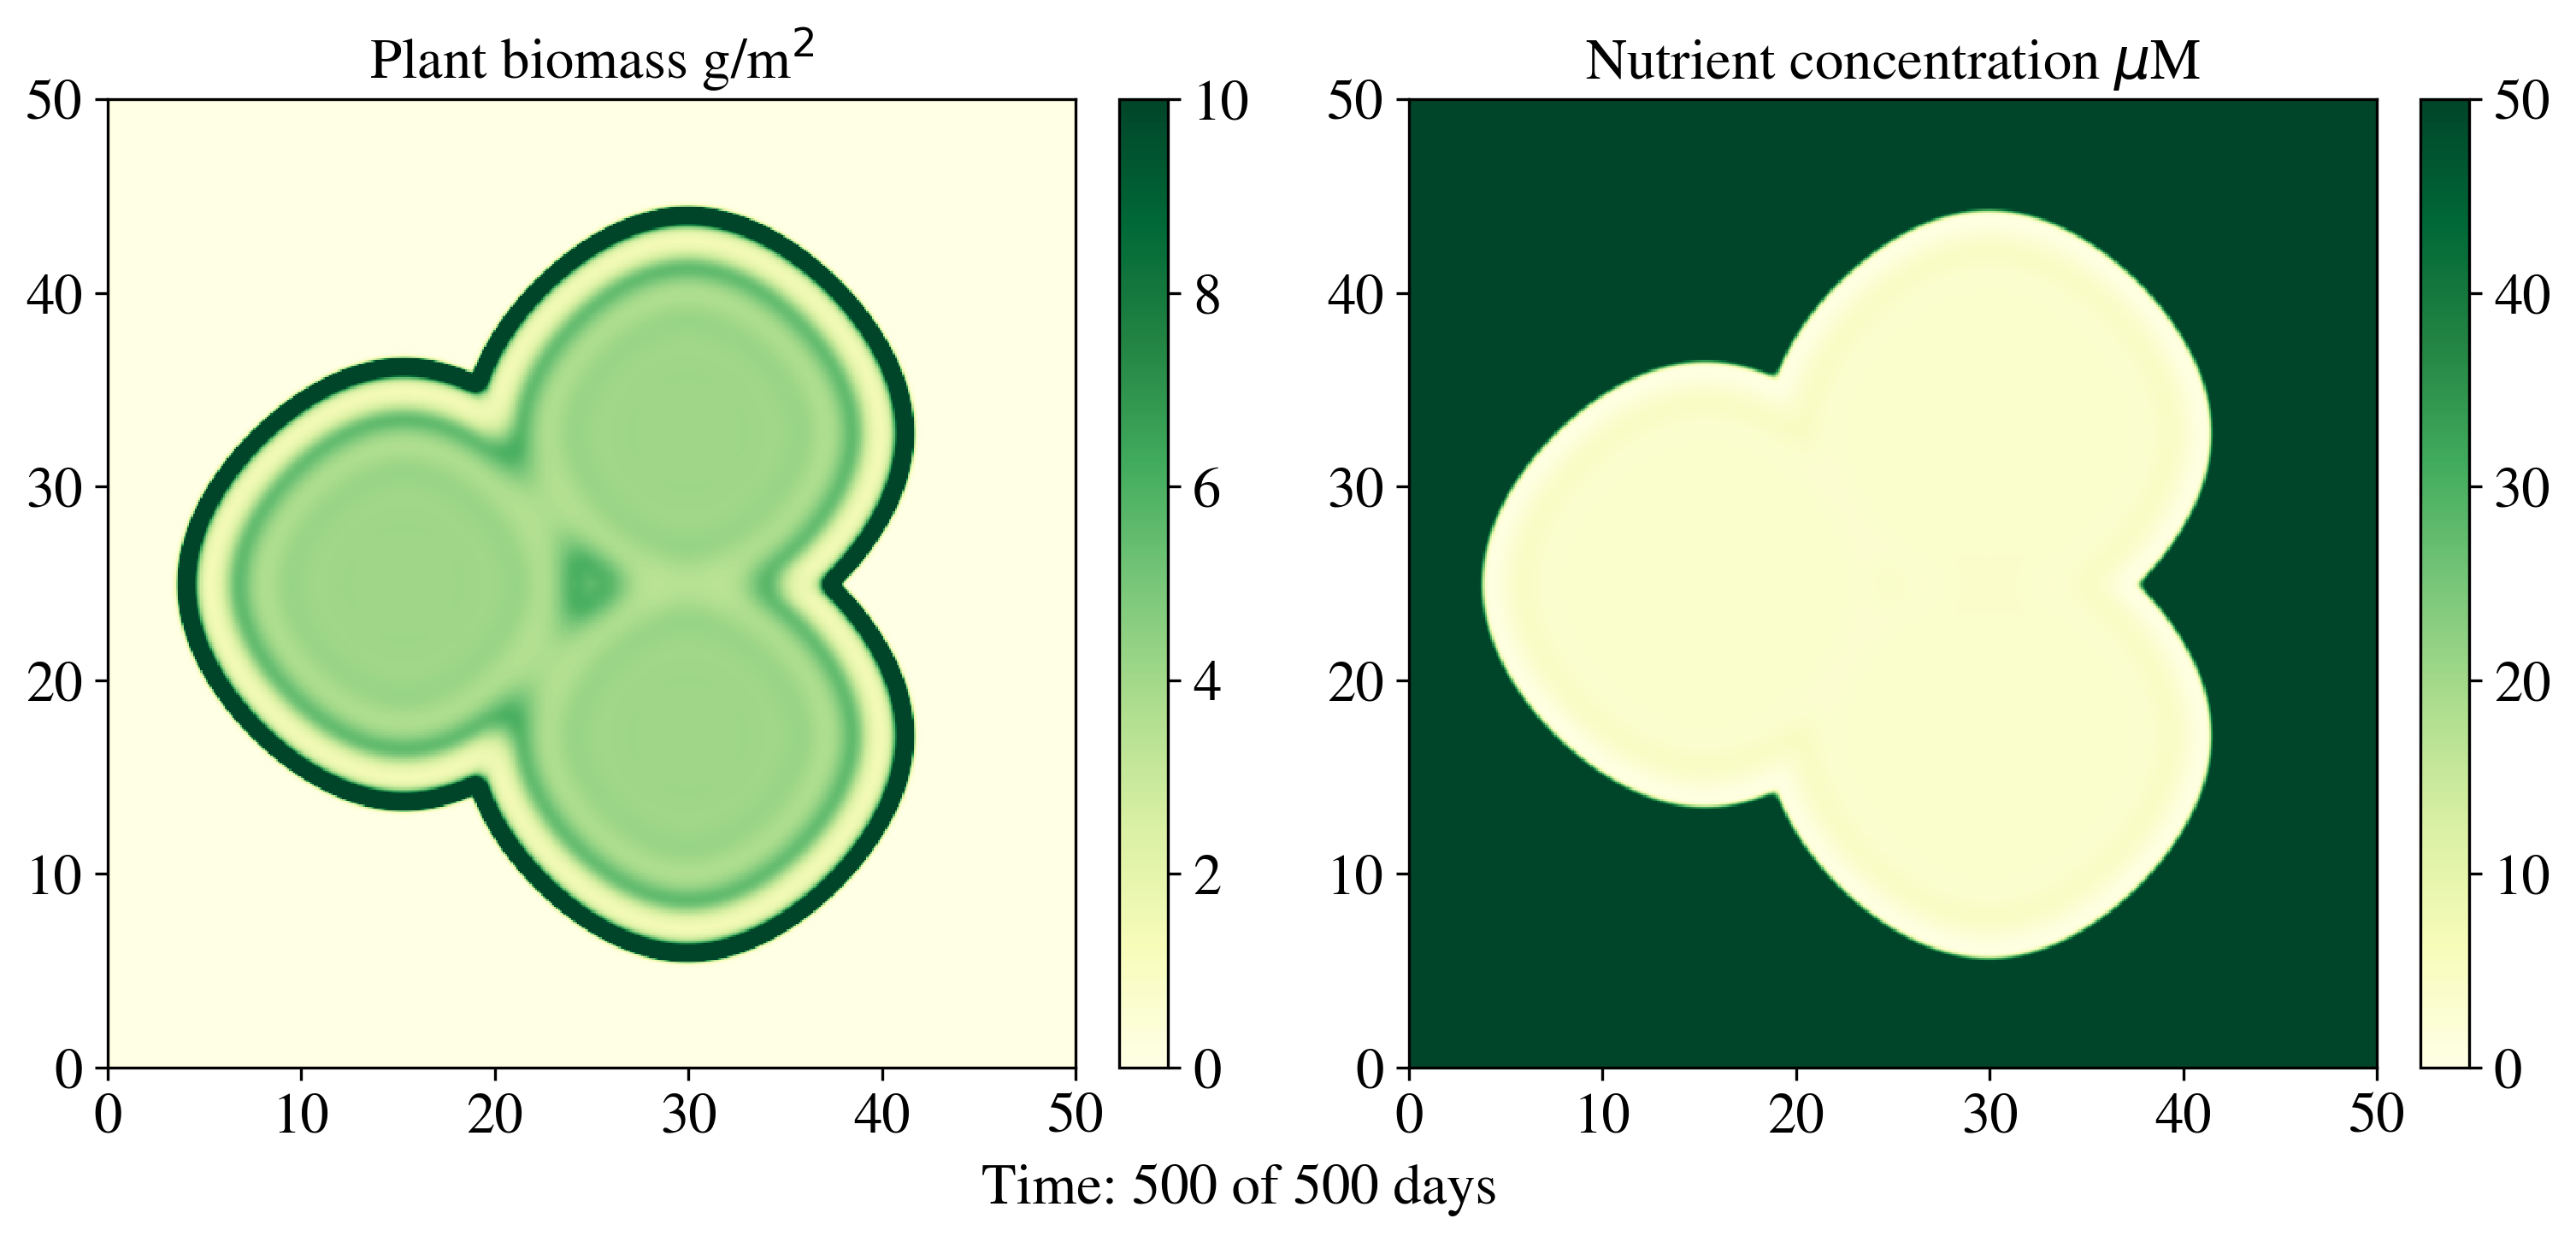

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

im0 = ax[0].imshow(P_host.reshape(n,n),cmap='YlGn',extent=[0,length,0,length], clim=(0,10));
plt.colorbar(im0, ax=ax[0],fraction=0.046,pad=0.04);ax[0].set_title('Plant biomass g/m$^2$');

im1 = ax[1].imshow(N_host.reshape(n,n),cmap='YlGn',extent=[0,length,0,length], clim=(0,50));
plt.colorbar(im1, ax=ax[1],fraction=0.046,pad=0.04);ax[1].set_title('Nutrient concentration $\mu$M');

text=fig.suptitle("Time: %1.0f of %1.0f days" % (endtime, endtime), x=0.5, y=0.05, fontsize=16);


### Making a movie

In [29]:
from matplotlib import animation, rc
import os
if not os.path.exists("oldSim"):
    os.makedirs("oldSim")
    
def updatefig(i): # To update the image at each iteration
    global Ps,Ns
    im0.set_array(Ps[:,:,i])
    im1.set_array(Ns[:,:,i])
    text.set_text("Time: %1.0f of %1.0f days" % ((i+1)/nplot*endtime, endtime));
    fig.savefig('oldSim/nutrient'+str(i)+'.pdf',bbox_inches='tight')
    return im0,im1,

#for ii in range(1,nplot):
#    updatefig(ii)
    
ani = animation.FuncAnimation(fig, updatefig, interval=100, frames = nplot, repeat=False, blit=True)

In [30]:
from IPython.display import HTML
HTML(ani.to_html5_video())

Writer = animation.writers['ffmpeg']
writer = Writer(fps=10, bitrate=1800)
ani.save('S2_Nutrient.mp4', writer=writer)

The End, Kang